<a href="https://colab.research.google.com/github/dmf49/CS5542/blob/master/icp11_dym49.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ICP11: Image Segmentation problem using U-NET architecture **

In this ICP, we are showing an exercise on U-Net image segmentation. U-Net is a modified CNN architrecture. It has a symmetric structure. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. The typical use of convolutional networks is on classification tasks, where
the output to an image is a single class label. However, in many visual tasks,
especially in biomedical image processing, the desired output should include
localization, i.e., a class label is supposed to be assigned to each pixel.

Its architecture can be broadly thought of as an encoder network followed by a decoder network. Unlike classification where the end result of the the deep network is the only important thing, semantic segmentation not only requires discrimination at pixel level but also a mechanism to project the discriminative features learnt at different stages of the encoder onto the pixel space.

A sample architecture diagram is shown below. The whole architecturelooks like a U-Shape. That's why it is called U-Net.

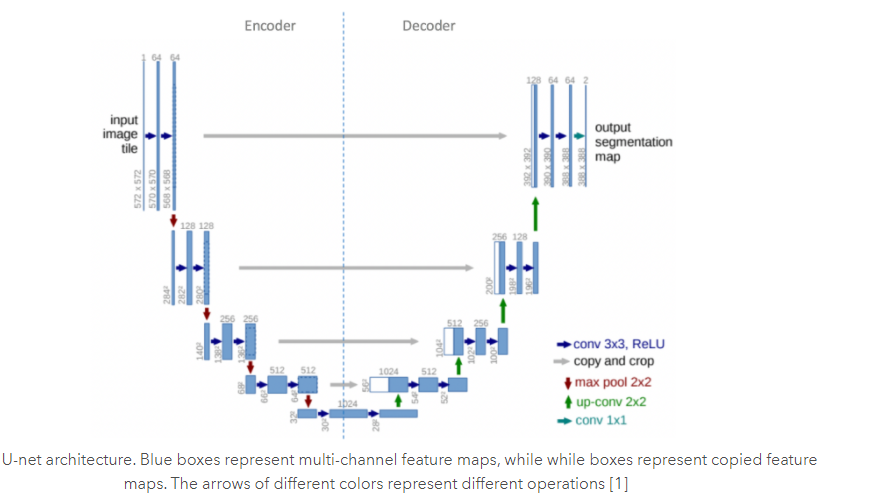



The encoder is the first half in the architecture diagram. The decoder is the second half of the architecture. The goal is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. The decoder consists of upsampling and concatenation followed by regular convolution operations.

In this classroom coding project, we are creating an algorithm to automate nucleus detection. Our goal is to develop a code using the data from the Kaggle Challenge: https://www.kaggle.com/c/data-science-bowl-2018/overview that creates a artificial neural network model that can identify a range of nuclei across varied conditions. We are using the U-Net architecture to accomplish this task.

I am now going through the code step by step.

First, we have imported the libraries for our exercise.

In [1]:
# U-Net image segmentation exercise

## Importing the modules necessary for the analysis
import tensorflow as tf
import os
import sys
import cv2
import random
import numpy as np # linear algebra
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras import backend as K
import matplotlib.pyplot as plt

I have followed the classroom instructions to use Kaggle data for this ICP. I have integrated Kaggle  with colab using the steps described in this link: https://www.kaggle.com/general/74235.


In [2]:
# We are using kaggle API functions to import the data
! pip install -q kaggle


In [3]:
## loading the API keys
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debmukhopadhyay","key":"110525bd3d1684a32576608181761a46"}'}

At this point, the Kaggle data is integrated with my colab workspace.

In [4]:
## Creatre/organize the directories to store and manage data and analysis
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json


The Kaggle dataset list can be viewed as follows.

In [6]:
! kaggle datasets list


ref                                                     title                                              size  lastUpdated          downloadCount  
------------------------------------------------------  -----------------------------------------------  ------  -------------------  -------------  
unanimad/us-election-2020                               US Election 2020                                  428KB  2020-11-23 12:01:34           7954  
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University          3MB  2020-11-23 06:03:57           3876  
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                           353MB  2020-11-09 18:51:59           3271  
headsortails/us-election-2020-presidential-debates      US Election 2020 - Presidential Debates           199MB  2020-10-23 16:56:10            616  
etsc9287/2020-general-election-polls                    Election, COVID, and Demographic Data by Cou

Now, we are downloading the specific data that is going to be used in this exercise.

In [7]:
!kaggle competitions download -c data-science-bowl-2018


  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 4.39MB/s]
 99% 273M/276M [00:03<00:00, 80.5MB/s]
100% 276M/276M [00:03<00:00, 88.5MB/s]
 83% 66.0M/79.1M [00:01<00:00, 48.7MB/s]
100% 79.1M/79.1M [00:01<00:00, 48.1MB/s]
 66% 6.00M/9.10M [00:00<00:00, 62.4MB/s]
100% 9.10M/9.10M [00:00<00:00, 58.2MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 104MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 181MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 120MB/s]


Now we unzip the data.

In [87]:
! unzip /content/stage1_train.zip -d train


Archive:  /content/stage1_train.zip
replace train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png  
replace train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Once unzipped, we can now see the data files on our colab IDE.





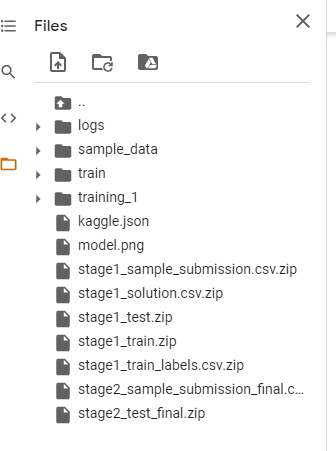

In this section, we handle the data and create the training samples using the python numpy arrays. Please refer to the specific acxtions on the comments made in the code below.

In general, this dataset contains a large number of segmented nuclei images. Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:


1.   images - contains the image file
2.   masks - contains the segmented masks of each nucleus.




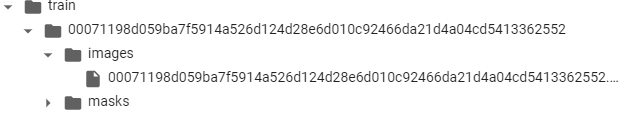



In [9]:
##################################
# Get the data
##################################
## import all the images and associated masks.
## We downsample both the training and test images to make our process light

#Specify some initial variables. 
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# DATA_PATH varible point to the data folder. We are  essentially pointed to everything in the data folder via this variable.
DATA_PATH = '/content/train/'


seed = 42

random.seed = seed
np.random.seed = seed

image_ids = next(os.walk(DATA_PATH))[1]

# creating two arrays to populate the training dataset for this assignment
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

## retrieving the images and masks
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = DATA_PATH + id_
    # getting images
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    # resizing the images
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), )
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask

x_train=X

y_train=Y

100%|██████████| 670/670 [01:04<00:00, 10.41it/s]


Now, we are checking if our training data looks good. We plot a random image and mask.

---



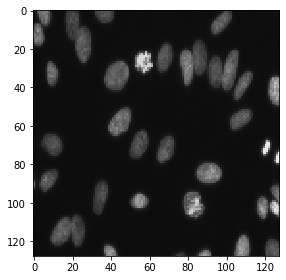

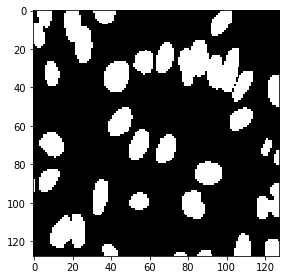

In [92]:
# Check if training data looks all right
ix = random.randint(0, len(image_ids))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()

The next step is to build the U-Net model. Please see the comments in the snippet below. In summary, c1 - c4 represent the contract part of the network, c5 is the bottleneck, and c6 - c9 are the upsampling part.

Note that I have introduced three changes in the model:


1.   Used the activation function from elu to relu. The RELU function is 

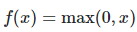


ReLUs improve neural networks is by speeding up training and the computational step of a ReLU is easy: any negative elements are set to 0. This is in contrast with ELU which becomes smooth slowly. 
2. Introduced an additional layer c7_additionalk in the upsampling stage. This is placed to prevent information loss after the bottleneck layer. 
3. Used a dropout value of 0.2 throughout the layers. This is done to avoid any overtfitting issues.







In [65]:
# Build U-Net model

## Inputs with the parameters IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# First Layer in the contraction path - conv2D; no padding is given
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_uniform',
                            padding='same')(s)
# setting dropout to be 0.2 - to avoid any over fitting
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_uniform',
                            padding='same')(c1)
#Using maxpooling to reduce the image size
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# Second layer in the contraction path
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_uniform',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.2)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_uniform',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# Third layer in the contraction path

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_uniform',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_uniform',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# Fourth layer in the contraction path

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

# Bottleneck layer
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(c5)

# First layer in the upsampling - using strides = (2,2) to increase the image size by a factor of 2
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# skip connection from c4 - (no skip connection for bottleneck)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(c6)

# Second layer in the upsampling 

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(u7)
## Introduced an additional layer to minimize losses after bottleneck
c7_additional = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_uniform',
                            padding='same')(c7)

c7 = tf.keras.layers.Dropout(0.2)(c7_additional)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_uniform',
                            padding='same')(c7)

# Third layer in the upsampling 

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_additional)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_uniform',
                            padding='same')(c9)

# output layer using sigmoid function
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

We now assign the model to a variable "model" in the code.

In [82]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


Once we created the model, we use a tensorFlow utility to visualize that. 

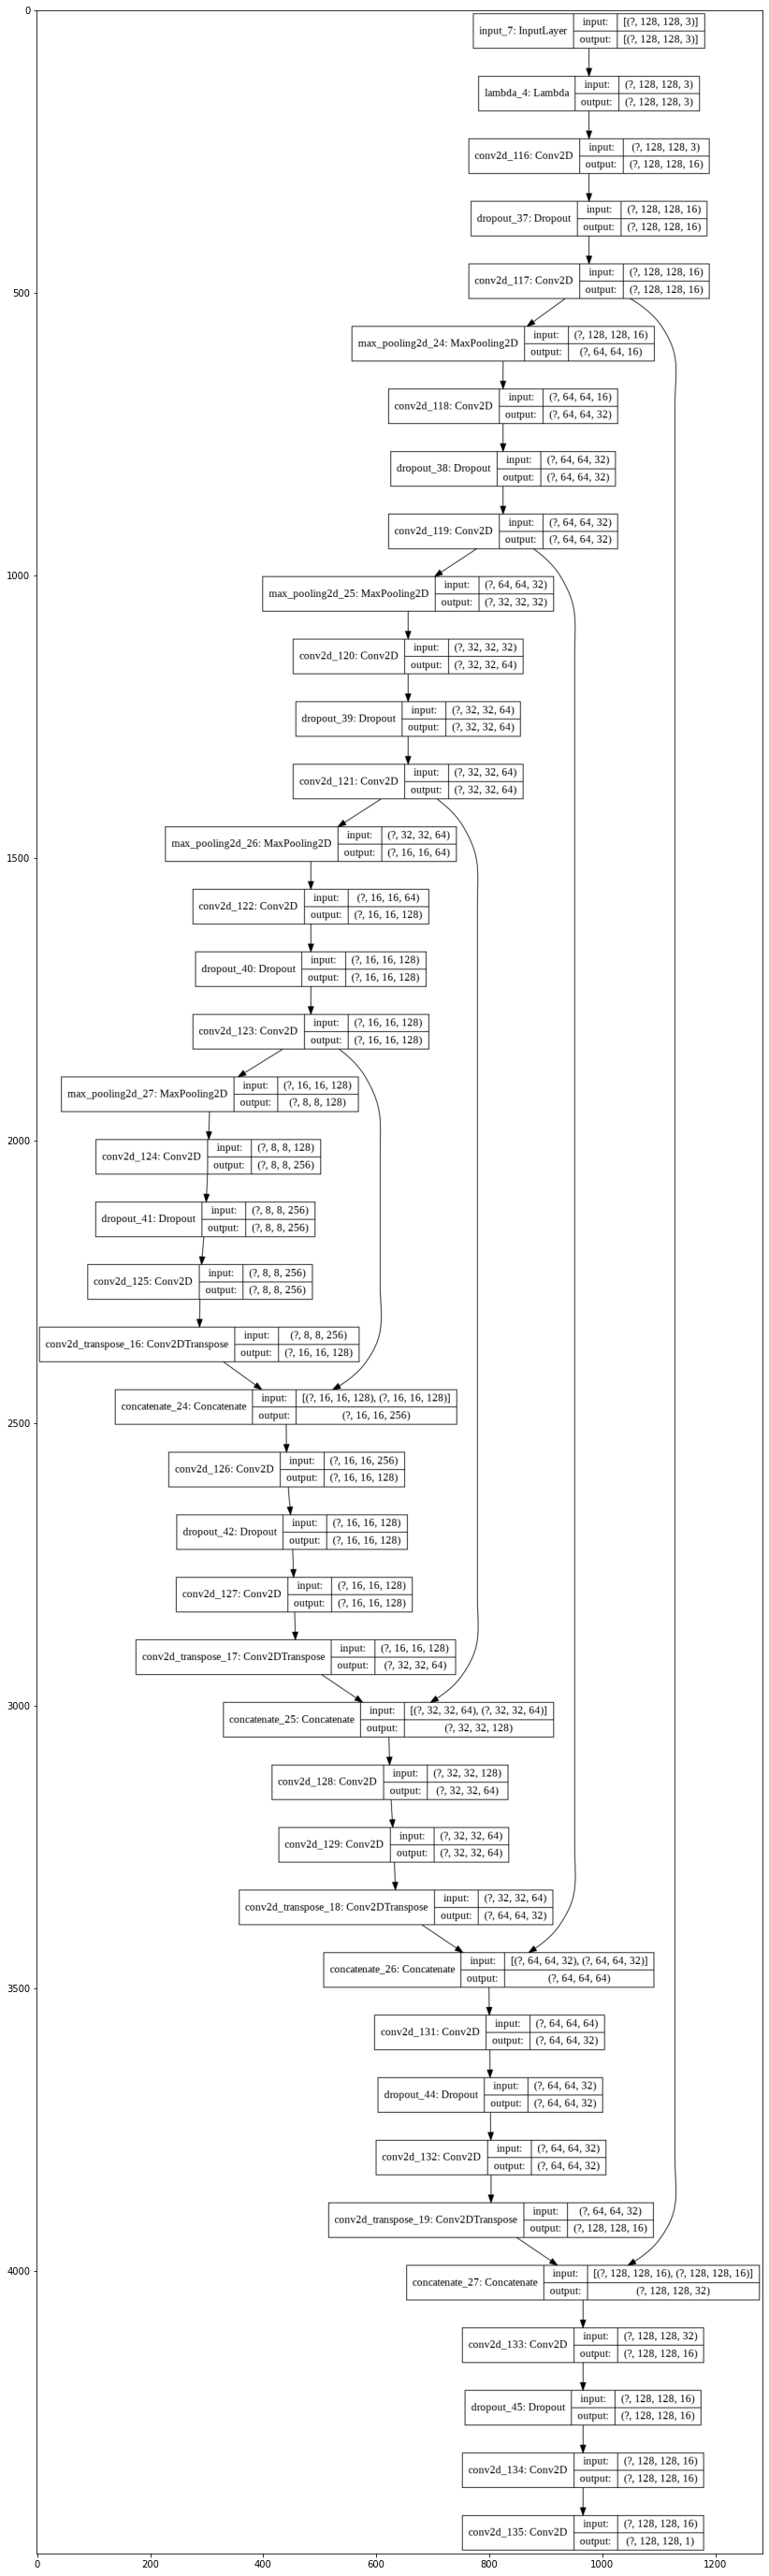

In [67]:
%matplotlib inline

from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('model.png')

plt.figure(figsize=(50, 50))
plt.imshow(img)

 We are dealing with a segmentation problem. In those cases, accuracy may not be an effective metric for the model evaluation. When we use accuracy as a metric, it finds the accuracy in both the nuclei identification and the background identification too. In this current context, we need accuracy in determining the nuclei.
 In the snippet below we show the dice accuracy measurement function. The variable "smooth" is introduced to avoid 0's in the denominator.

In [83]:
## function to formulate dice accuracy
## input paramneters : actual y and predicted y
def dice_acc(y_true, y_pred):
  # ensuring that we dont encounter 0's in the denominator
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    ### dice score formula
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

The model is compiled below with a loss function of "binary_crossentropy". Cross Entropy is  a good loss function for Classification Problems, because it minimizes the distance between two probability distributions - predicted and actual. So, cross entropy makes sure that we are minimizing the difference between the two probabilities. 


In [84]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_acc])

model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 128, 16) 0           conv2d_116[0][0]                 
______________________________________________________________________________________

In the code-snippet below, we are running the model. We have made a change in the callbacks. In the EarlyStopping, I have specified a patience level of 10. I have specified the earlystopping based on the validation loss. If my validation loss is not improving within 10 patient level or within 10 epochs, then I stop the run. By specifying a greater patience level, I am allowing the model a bit more opportunity (compared to a lower patient level) to determine that the validation loss is not improving. 
Setting a patient level to 10 is the fourth change I have made compared to the classroom example.

I have made two more changes. First, I altered the hyperparameter epochs = 200 to allow the U-Net system to fit the model with enough iteration until the EarklyStop is called. 

I have also increased  the batch size to 64 to populate our training sample with a higher statistics before the model is updated.

In [85]:

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', verbose=1),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]
epochs = 200
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=64, epochs=epochs,callbacks=callbacks)

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 0.0268 - dice_acc: 0.8638
Epoch 00001: saving model to training_1/cp.ckpt
9/9 [==============================] - 2s 237ms/step - loss: 0.0268 - dice_acc: 0.8638 - val_loss: 0.0267 - val_dice_acc: 0.8642
Epoch 2/200
9/9 [==============================] - ETA: 0s - loss: 0.0235 - dice_acc: 0.8610
Epoch 00002: saving model to training_1/cp.ckpt
9/9 [==============================] - 1s 158ms/step - loss: 0.0235 - dice_acc: 0.8610 - val_loss: 0.0259 - val_dice_acc: 0.8573
Epoch 3/200
9/9 [==============================] - ETA: 0s - loss: 0.0222 - dice_acc: 0.8632
Epoch 00003: saving model to training_1/cp.ckpt
9/9 [==============================] - 1s 158ms/step - loss: 0.0222 - dice_acc: 0.8632 - val_loss: 0.0258 - val_dice_acc: 0.8649
Epoch 4/200
9/9 [==============================] - ETA: 0s - loss: 0.0211 - dice_acc: 0.8703
Epoch 00004: saving model to training_1/cp.ckpt
9/9 [==============================] - 1s 157ms/s

To validate the model performance, I pick up a random image and then evaluate how the model predicts on that image.

The original image and the predicted image are found to be very close.

1/1 [==============================] - 0s 3ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


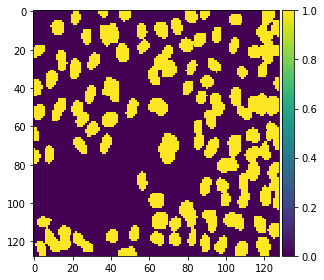

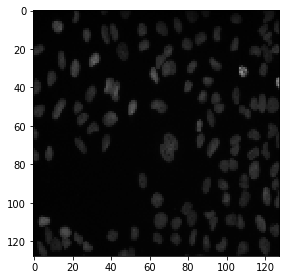

In [90]:
idx = random.randint(0, len(x_train))
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)

## identifying the nuclei if the predict is > 0.5 (sigmoid function) 
predict = (predict > 0.5).astype(np.uint8)

## drawing the plot of the prediction
imshow(np.squeeze(predict[0]))
plt.show()

#drawing the actual image
imshow(x_train[idx])

plt.show()